#### Performing density regression using TT-parametrized ODE flows

In Rohrbach et al. 2020, a-priori rank bounds are developed for FTT representations in Gaussian models, demonstrating that under certain conditions, high-accuracy approximations can be achieved without exponential complexity growth as dimensions increase. This motivates the following technical approach for our regression model. 

For an exponential function
$$
\exp_g(x) := \exp(g(x)),
$$
with continuous $g$, such as the Gaussian with $g(x) = x^T \Gamma x$, we can define a function $f \in \mathcal{C}(\mathbb{R}^{d+1}, \mathbb{R}^{d+1})$ and an ODE
$$
\dot{x}(t) = f(x(t)), \quad t \in [0, 1],
$$
with
$$
x(0) = \begin{pmatrix} 1 \\ \mathbf{x} \end{pmatrix},
$$
such that $x(1)_1 = \exp(g(x))$. Following the approach of David Sommer, in particular, this holds true for
$$
f(x) = \begin{pmatrix} g(x_{2:d+1}) x_1 \\ 0_d \end{pmatrix}.
$$


Further, 
$$
g(x) = x^T \Gamma x, \quad x \in \mathbb{R}^d, \quad \Gamma \in \mathbb{R}^{d \times d}
$$
has FTT ranks bounded by $2 + \frac{d}{2}$.


For our experiments, we will assume that we can represent the function as
$$
f(x) = \begin{pmatrix} u_\theta(x_{2:d+1}) x_1 \\ 0_d \end{pmatrix}, 
$$
where $u_\theta$ is a FTT of the form 
$$
u_\theta(t, x_1, \ldots, x_d) = \sum_{i_1=0}^{m} \cdots \sum_{i_d=0}^{m} 
\hat{U}(i_1, \cdot) \hat{U}(\cdot, i_2, \cdot) \cdots \hat{U}(\cdot, i_{d+1}, \cdot)
P_{i_1}(t) P_{i_2}(x_1) \cdots P_{i_{d+1}}(x_d), 
$$
with ranks $r_0 = 1, r_{d+1} = d, r_1 = \ldots, r_d = r$ for any a priori set $r \in \N$.



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import ExtendedFlowODE

# torch.manual_seed(42)
# np.random.seed(42)

In [18]:
def generate_gaussian_data(d: int, Gamma: torch.Tensor, n_samples: int, scaling: bool = False):
    """
    Generates labeled training data for the density of a d-dimensional Gaussian.
    """
    
    x_samples = torch.randn(n_samples, d)
    
    # Precompute constants for the Gaussian density function
    Gamma_inv = torch.inverse(Gamma)
    scaling_factor = (1-int(scaling)) + int(scaling) * torch.tensor(1) / torch.sqrt((2 * torch.pi) ** d * torch.det(Gamma_inv))
    
    # Compute the corresponding y = exp(x.T @ Gamma @ x) for each sample
    y_samples = torch.zeros(n_samples)

    for i in range(n_samples):
        x = x_samples[i]
        # Gaussian density function: scaling * exp(-0.5 * (x.T @ Gamma_inv @ x))
        exponent = -0.5 * (x.T @ Gamma @ x)
        y_samples[i] = scaling_factor * torch.exp(exponent)

    return x_samples, y_samples

In [19]:
def gaussian_density(x: torch.Tensor, Gamma: torch.Tensor, scaling: bool = False) -> torch.Tensor:
    """
    Evaluates the density of a d-dimensional Gaussian on single or batched data points.
    """
    
    d = x.shape[-1]

    if x.ndim == 1:
        x = x.unsqueeze(0)  # Add batch dimension, making x shape (1, d)

    # Precompute constants for the Gaussian density function
    Gamma_inv = torch.inverse(Gamma)
    scaling_factor = (1 - int(scaling)) + int(scaling) * torch.tensor(1) / torch.sqrt((2 * torch.pi) ** d * torch.det(Gamma_inv))

    # Compute the corresponding y = exp(x.T @ Gamma @ x) for each point in the batch
    exponent = -0.5 * torch.einsum('bi,ij,bj->b', x, Gamma, x)

    # Gaussian density function: scaling * exp(-0.5 * (x.T @ Gamma_inv @ x))
    y = scaling_factor * torch.exp(exponent)

    return y


In [20]:
# Loss function
def loss_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)

    result = ((y_pred - y) ** 2) + lambda_transport_reg * l2_transport_cost
    return result.mean() + lambda_tt_reg * tt_regularization

In [21]:
# Absolute error
def abs_error_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool):

    y_pred = model(x, ts, rtol, atol, method, backward)

    abs_result = ((y_pred - y) ** 2).mean()
    return abs_result

In [22]:
# Relative error
def rel_error_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool):

    y_pred = model(x, ts, rtol, atol, method, backward)
    
    abs_result = ((y_pred - y) ** 2).mean()
    norm_y = (y ** 2).mean()
    result = abs_result / norm_y
    return result

##### Approximating a Gaussian density in 2D

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [23]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [24]:
# Training parameters
n_samples = 256
n_epochs = 250
batch_size = 64
learning_rate = 1e-3

In [25]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(2)

data, target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [26]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [27]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/250], Loss: 0.8844, Absolute Error: 0.8827, Relative Error: 110.81, Transport Cost: 0.0004
Epoch [2/250], Loss: 0.8746, Absolute Error: 0.8729, Relative Error: 108.34, Transport Cost: 0.0003
Epoch [3/250], Loss: 0.8679, Absolute Error: 0.8662, Relative Error: 107.71, Transport Cost: 0.0001
Epoch [4/250], Loss: 0.8626, Absolute Error: 0.8609, Relative Error: 105.89, Transport Cost: 0.0001
Epoch [5/250], Loss: 0.8590, Absolute Error: 0.8573, Relative Error: 107.50, Transport Cost: 0.0000
Epoch [6/250], Loss: 0.8562, Absolute Error: 0.8545, Relative Error: 105.06, Transport Cost: 0.0000
Epoch [7/250], Loss: 0.8547, Absolute Error: 0.8531, Relative Error: 105.96, Transport Cost: 0.0000
Epoch [8/250], Loss: 0.8535, Absolute Error: 0.8519, Relative Error: 104.76, Transport Cost: 0.0000
Epoch [9/250], Loss: 0.8526, Absolute Error: 0.8509, Relative Error: 104.08, Transport Cost: 0.0000
Epoch [10/250], Loss: 0.8516, Absolute Error: 0.8500, Relative Error: 105.

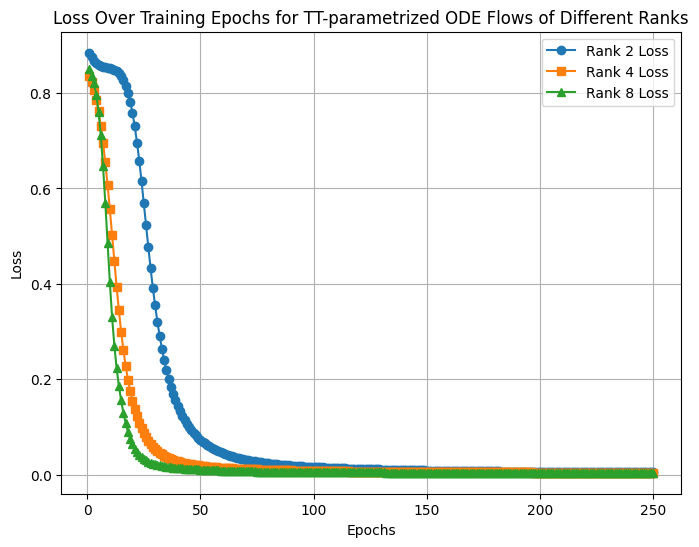

In [28]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [29]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2., 2., n)
test_data_x_2 = torch.linspace(-2., 2., n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

# Define the target Gaussian function
Gamma = torch.eye(2)  

TT-rank 2: Absolute squared error of 0.0019 and relative squared error of 0.41 on test data grid.
TT-rank 4: Absolute squared error of 0.0006 and relative squared error of 0.13 on test data grid.
TT-rank 8: Absolute squared error of 0.0002 and relative squared error of 0.05 on test data grid.


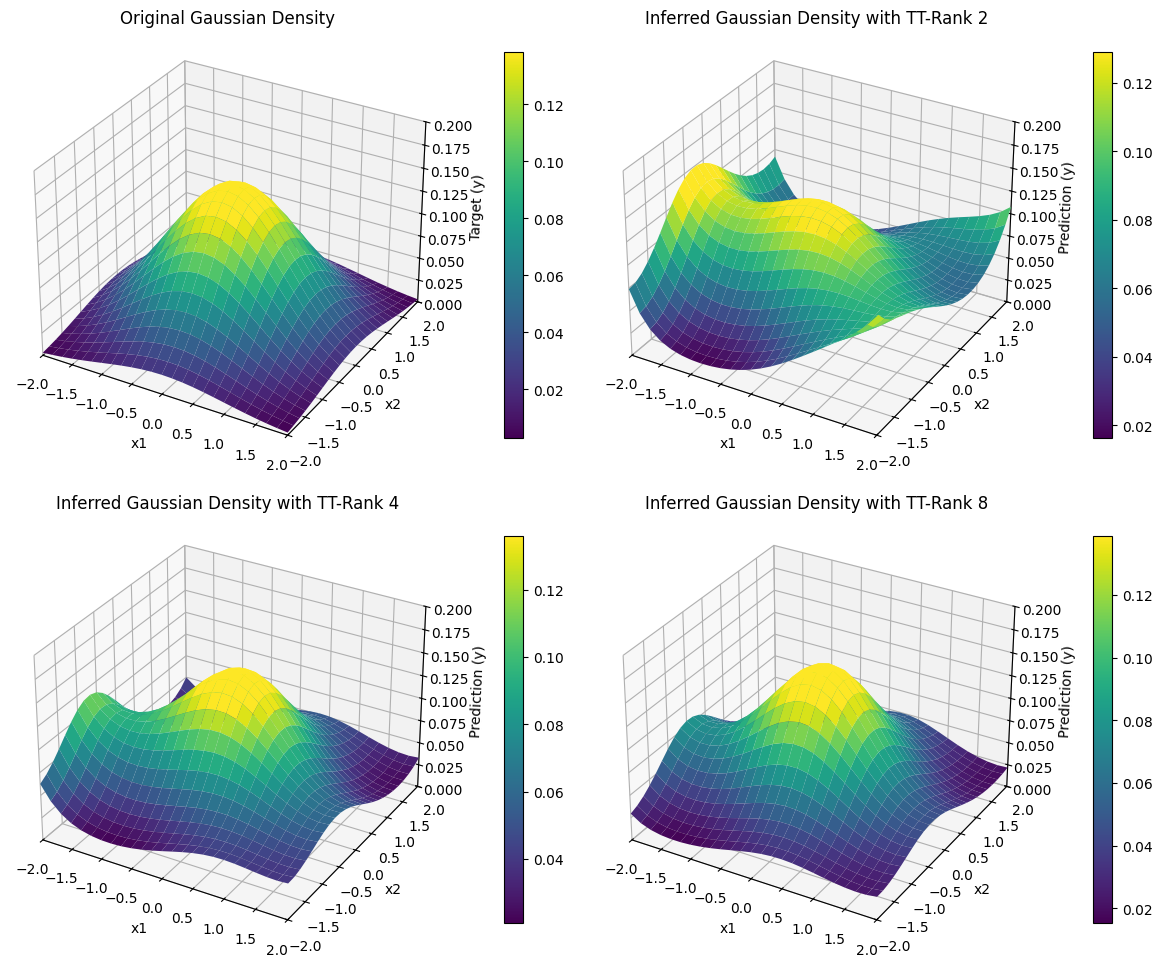

In [32]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

2. **Fourier basis:**

    Next, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Fourier  basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [65]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 3

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [68]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [69]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

Gamma = torch.tensor([[1., 0.], [0.,1.]])

data , target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [71]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [77]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/50], Loss: 0.3449, Transport Cost: 0.0322
Epoch [2/50], Loss: 0.3342, Transport Cost: 0.0347
Epoch [3/50], Loss: 0.3238, Transport Cost: 0.0380
Epoch [4/50], Loss: 0.3134, Transport Cost: 0.0329
Epoch [5/50], Loss: 0.3030, Transport Cost: 0.0416
Epoch [6/50], Loss: 0.2929, Transport Cost: 0.0456
Epoch [7/50], Loss: 0.2829, Transport Cost: 0.0477
Epoch [8/50], Loss: 0.2731, Transport Cost: 0.0490
Epoch [9/50], Loss: 0.2633, Transport Cost: 0.0531
Epoch [10/50], Loss: 0.2539, Transport Cost: 0.0590
Epoch [11/50], Loss: 0.2446, Transport Cost: 0.0576
Epoch [12/50], Loss: 0.2356, Transport Cost: 0.0705
Epoch [13/50], Loss: 0.2266, Transport Cost: 0.0694
Epoch [14/50], Loss: 0.2181, Transport Cost: 0.0800
Epoch [15/50], Loss: 0.2096, Transport Cost: 0.0827
Epoch [16/50], Loss: 0.2015, Transport Cost: 0.0842
Epoch [17/50], Loss: 0.1934, Transport Cost: 0.0852
Epoch [18/50], Loss: 0.1857, Transport Cost: 0.0866
Epoch [19/50], Loss: 0.1783, Transport Cost: 0.

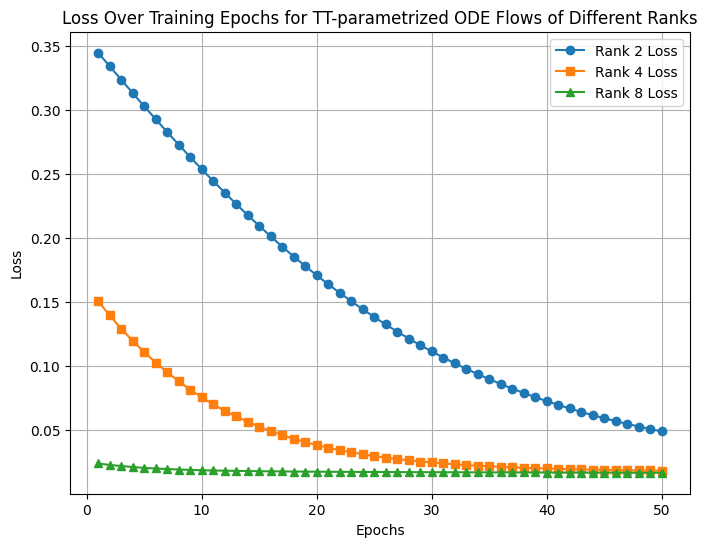

In [78]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [79]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2., 2., n)
test_data_x_2 = torch.linspace(-2., 2., n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

# Define the target Gaussian function
Gamma = torch.eye(2) 

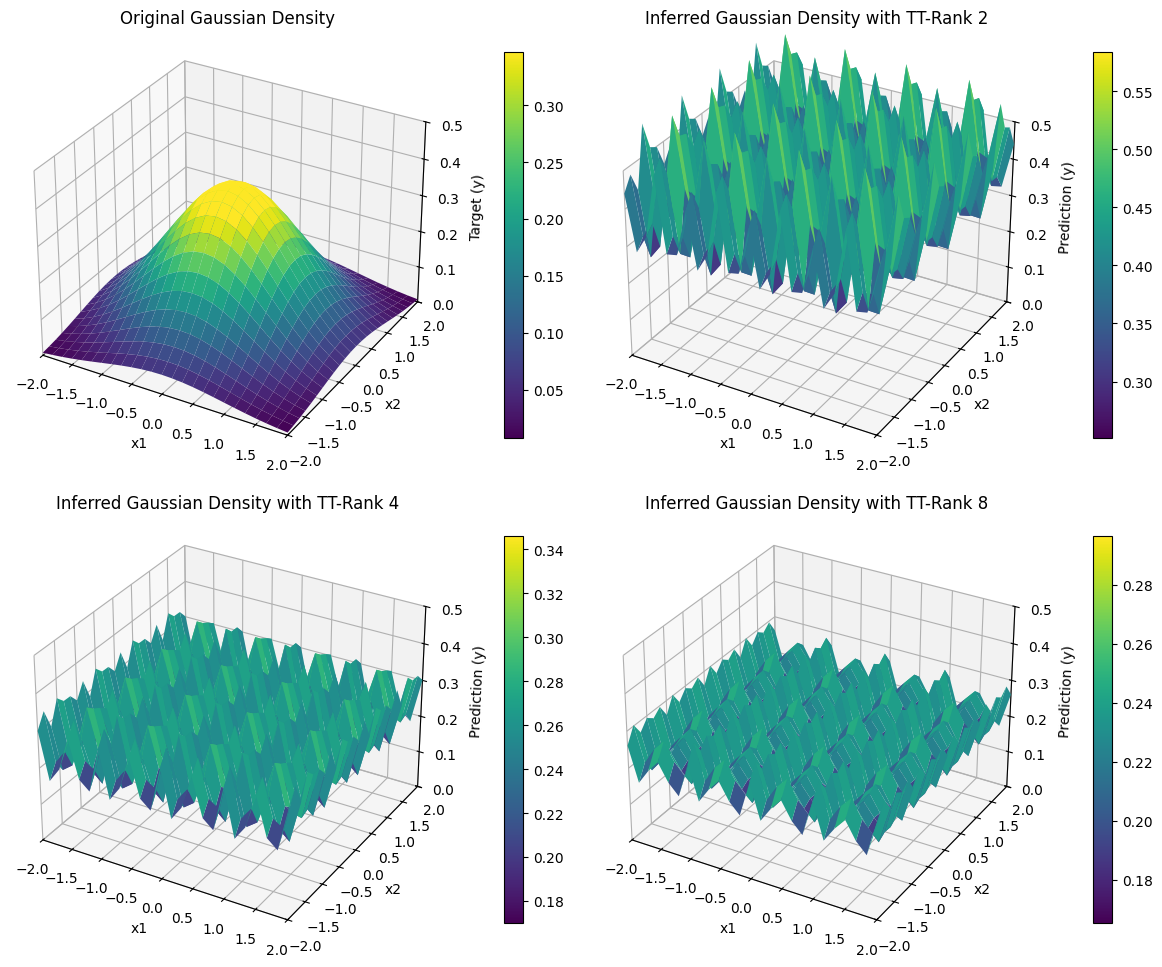

In [80]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

3. **B-Splines:**

    Now, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using **B-Splines of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [7]:
# Test implementation of B-spline basis
degree = 3
d = 3
bases = [
        BSpline1D(torch.linspace(-5, 5, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [8]:
# Training parameters
n_samples = 256
n_epochs = 250
batch_size = 64
learning_rate = 1e-3

In [9]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

Gamma = torch.tensor([[1., 0.], [0.,1.]])

data , target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

/var/folders/rc/9s_11zv502jcx5bnwgh4bmr00000gn/T/ipykernel_65943/1090877103.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  exponent = -0.5 * (x.T @ Gamma @ x)


In [11]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [12]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/250], Loss: 0.8608, Absolute Error: 0.8591, Relative Error: 113.62, Transport Cost: 0.0000
Epoch [2/250], Loss: 0.8606, Absolute Error: 0.8589, Relative Error: 113.59, Transport Cost: 0.0000
Epoch [3/250], Loss: 0.8605, Absolute Error: 0.8588, Relative Error: 114.75, Transport Cost: 0.0000
Epoch [4/250], Loss: 0.8604, Absolute Error: 0.8587, Relative Error: 113.53, Transport Cost: 0.0000
Epoch [5/250], Loss: 0.8602, Absolute Error: 0.8586, Relative Error: 115.11, Transport Cost: 0.0000
Epoch [6/250], Loss: 0.8601, Absolute Error: 0.8585, Relative Error: 116.37, Transport Cost: 0.0000
Epoch [7/250], Loss: 0.8600, Absolute Error: 0.8584, Relative Error: 114.16, Transport Cost: 0.0000
Epoch [8/250], Loss: 0.8598, Absolute Error: 0.8583, Relative Error: 116.37, Transport Cost: 0.0000
Epoch [9/250], Loss: 0.8596, Absolute Error: 0.8581, Relative Error: 113.68, Transport Cost: 0.0000
Epoch [10/250], Loss: 0.8594, Absolute Error: 0.8579, Relative Error: 113.

KeyboardInterrupt: 

In [1]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

NameError: name 'training_dict' is not defined

In [ ]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2., 2., n)
test_data_x_2 = torch.linspace(-2., 2., n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

# Define the target Gaussian function
Gamma = torch.eye(2) 

In [ ]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()


##### Approximating a Gaussian density in 5D

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [40]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 6

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [41]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [43]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [45]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [48]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/50], Loss: 0.0348, Transport Cost: 1.1948
Epoch [2/50], Loss: 0.0327, Transport Cost: 1.1721
Epoch [3/50], Loss: 0.0306, Transport Cost: 1.3178
Epoch [4/50], Loss: 0.0286, Transport Cost: 1.1777
Epoch [5/50], Loss: 0.0270, Transport Cost: 1.4824
Epoch [6/50], Loss: 0.0256, Transport Cost: 1.2976
Epoch [7/50], Loss: 0.0241, Transport Cost: 1.3074
Epoch [8/50], Loss: 0.0231, Transport Cost: 1.4986
Epoch [9/50], Loss: 0.0221, Transport Cost: 1.7762
Epoch [10/50], Loss: 0.0210, Transport Cost: 1.4385
Epoch [11/50], Loss: 0.0202, Transport Cost: 1.5681
Epoch [12/50], Loss: 0.0194, Transport Cost: 1.4508
Epoch [13/50], Loss: 0.0186, Transport Cost: 1.5435
Epoch [14/50], Loss: 0.0180, Transport Cost: 1.8318
Epoch [15/50], Loss: 0.0174, Transport Cost: 1.7535
Epoch [16/50], Loss: 0.0169, Transport Cost: 1.4878
Epoch [17/50], Loss: 0.0164, Transport Cost: 1.6596
Epoch [18/50], Loss: 0.0160, Transport Cost: 1.9134
Epoch [19/50], Loss: 0.0156, Transport Cost: 1.

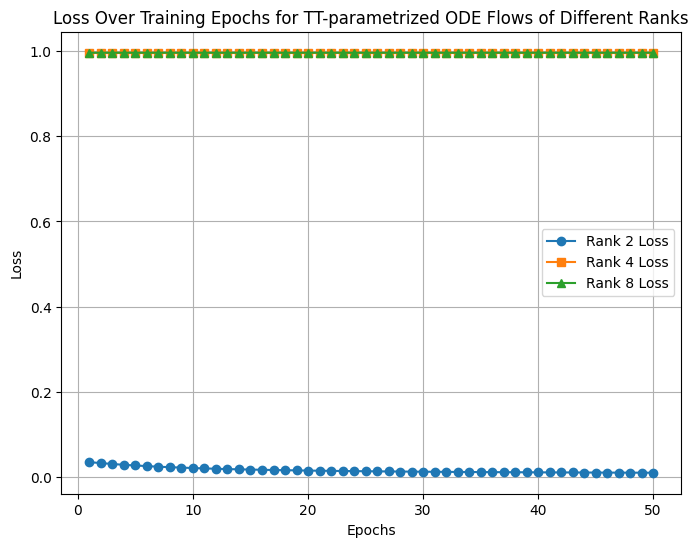

In [49]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

2. **Fourier basis:**

    Next, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Fourier  basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [ ]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 6

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

In [ ]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [ ]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [ ]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [ ]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")

In [ ]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

3. **B-Splines:**

    Now, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using **B-Splines of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [ ]:
# Test implementation of B-spline basis
degree = 3
d = 6
bases = [
        BSpline1D(torch.linspace(-5, 5, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

In [ ]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [ ]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [ ]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [ ]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")

In [ ]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()